# coco format 시각화 & EDA

In [1]:
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from glob import glob
from PIL import Image

In [30]:
data_dir = '/workspace/data/tld_db/train'
img_dir = f'{data_dir}/images'
df_path = f'{data_dir}/annotations.json'
with open(df_path) as f:
    data = json.load(f)

In [31]:
print(data['info'])
print(data['licenses'])
print(data['categories'])
print(data['images'][0])
print(data['annotations'][0])

{'year': 2024, 'version': '1.0.0', 'description': 'traffic light', 'contributor': 'tlfromj', 'url': '', 'date_created': '2024-10-02 21:00:00'}
[{'id': 0, 'name': None, 'url': None}]
[{'id': 0, 'name': 'veh_go', 'supercategory': 'veh_go'}, {'id': 1, 'name': 'veh_goLeft', 'supercategory': 'veh_goLeft'}, {'id': 2, 'name': 'veh_noSign', 'supercategory': 'veh_noSign'}, {'id': 3, 'name': 'veh_stop', 'supercategory': 'veh_stop'}, {'id': 4, 'name': 'veh_stopLeft', 'supercategory': 'veh_stopLeft'}, {'id': 5, 'name': 'veh_stopWarning', 'supercategory': 'veh_stopWarning'}, {'id': 6, 'name': 'veh_warning', 'supercategory': 'veh_warning'}, {'id': 7, 'name': 'ped_go', 'supercategory': 'ped_go'}, {'id': 8, 'name': 'ped_noSign', 'supercategory': 'ped_noSign'}, {'id': 9, 'name': 'ped_stop', 'supercategory': 'ped_stop'}, {'id': 10, 'name': 'bus_go', 'supercategory': 'bus_go'}, {'id': 11, 'name': 'bus_noSign', 'supercategory': 'bus_noSign'}, {'id': 12, 'name': 'bus_stop', 'supercategory': 'bus_stop'}, {'

In [4]:
categories = [data['name'] for data in data['categories']]

In [5]:
df = pd.DataFrame({
    'image_id':[],
    "category_id":[],
    'bbox_x':[],
    'bbox_y':[],
    'bbox_w':[],
    'bbox_h':[],
    'ratio':[],
    'area':[]
    })

for i, annos in tqdm(enumerate(data['annotations'])):
    df.loc[i] = [
        int(annos['image_id']),
        int(annos['category_id']),
        annos['bbox'][0],
        annos['bbox'][1],
        annos['bbox'][2],
        annos['bbox'][3],
        round(annos['bbox'][2]/annos['bbox'][3],1),
        annos['area'],
        ]

print(df.head())

0it [00:00, ?it/s]

   image_id  category_id     bbox_x     bbox_y    bbox_w   bbox_h  ratio  \
0       0.0          3.0  690.00064  165.00000  12.99968  6.00000    2.2   
1       0.0          3.0  709.00032  163.99992  13.99936  5.00016    2.8   
2       1.0          3.0  657.00032  157.99992  13.99936  5.00016    2.8   
3       1.0          3.0  677.00032  156.99984  13.99936  6.00000    2.3   
4       2.0          3.0  632.99968  149.99976  12.99968  5.00016    2.6   

       area  
0  77.99808  
1  69.99904  
2  69.99904  
3  83.99616  
4  65.00048  


# 이미지들의 크기와 RGB 평균 및 표준편차

In [6]:
def get_img_stats(img_dir, img_ids):
    """
    데이터셋에 있는 이미지들의 크기와 RGB 평균 및 표준편차를 수집하는 함수입니다.

    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로
        img_ids: 학습 데이터셋 하위폴더 이름들

    Returns:
        img_info: 이미지들의 정보 (크기, 평균, 표준편차)
    """
    img_info = dict(heights=[], widths=[], means=[], stds=[], area=[])
    for img_name in tqdm(img_ids):
        for path in glob(os.path.join(img_dir, img_name)):
            img = np.array(Image.open(path))
            h, w, _ = img.shape
            img_info['heights'].append(h)
            img_info['widths'].append(w)
            img_info['means'].append(img.mean(axis=(0,1)))
            img_info['stds'].append(img.std(axis=(0,1)))
    return img_info

In [7]:
img_info = get_img_stats(img_dir, os.listdir(img_dir)[:])

print(f'Total number of annotation is {len(df)}')
print(f'Total number of images is {len(os.listdir(img_dir))}')

print(f'Minimum height for dataset is {np.min(img_info["heights"])}')
print(f'Maximum height for dataset is {np.max(img_info["heights"])}')
print(f'Average height for dataset is {int(np.mean(img_info["heights"]))}')
print(f'Minimum width for dataset is {np.min(img_info["widths"])}')
print(f'Maximum width for dataset is {np.max(img_info["widths"])}')
print(f'Average width for dataset is {int(np.mean(img_info["widths"]))}')

print(f'RGB Mean: {np.mean(img_info["means"], axis=0)}')
print(f'RGB Standard Deviation: {np.mean(img_info["stds"], axis=0)}')

  0%|          | 0/26864 [00:00<?, ?it/s]

Total number of annotation is 87617
Total number of images is 26864
Minimum height for dataset is 480
Maximum height for dataset is 1536
Average height for dataset is 777
Minimum width for dataset is 1280
Maximum width for dataset is 2048
Average width for dataset is 1310
RGB Mean: [129.15828195 128.14243564 134.22255427]
RGB Standard Deviation: [54.23744407 53.05058442 56.72761661]


# 카테고리별 bounding box 개수

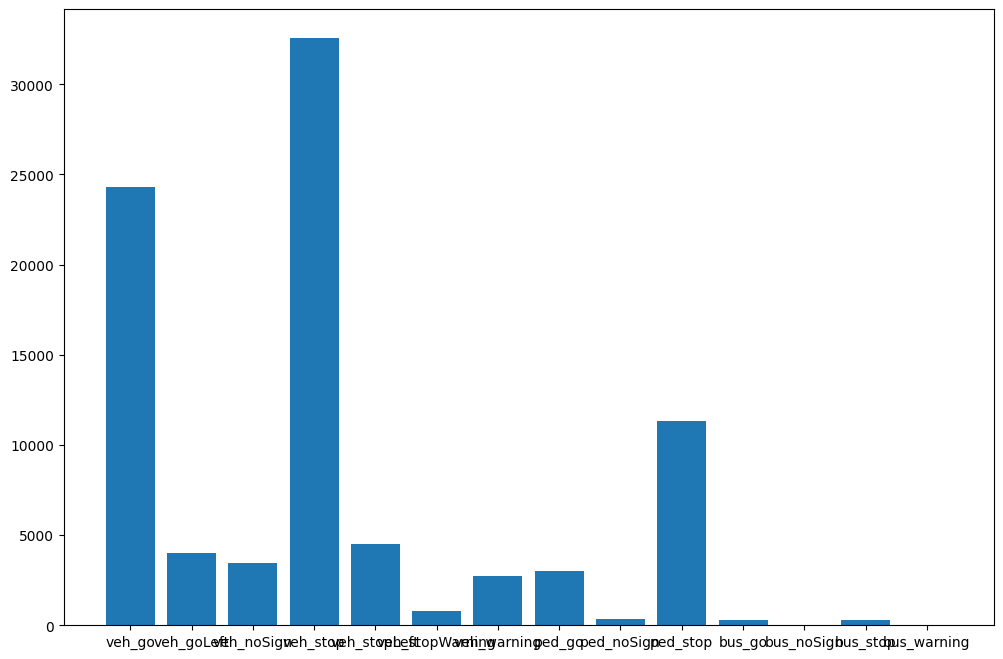

In [8]:
category_counts = df['category_id'].value_counts().sort_index()
categories_num = np.arange(len(categories))
plt.figure(figsize = (12,8))
plt.bar(categories_num, category_counts)
plt.xticks(categories_num, categories)
plt.show()

# 한 개의 이미지에 bounding box가 몇개 존재하는지

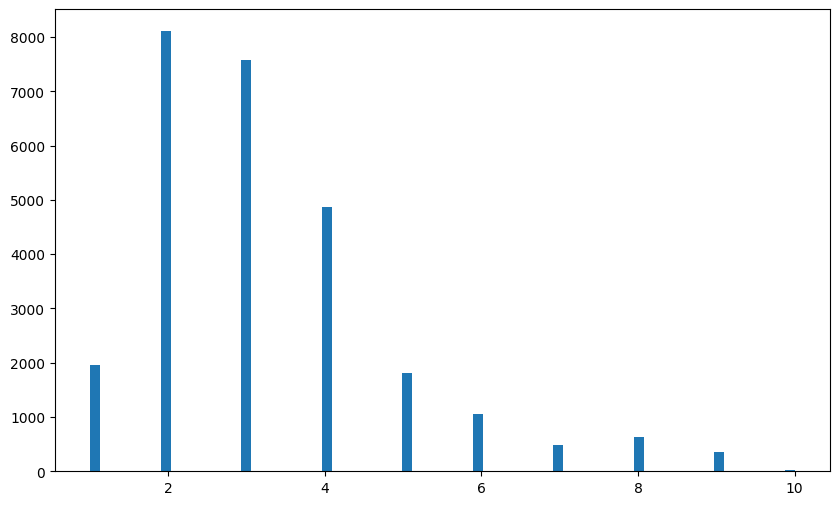

image_id
4761.0     10
4770.0     10
4757.0     10
4758.0     10
4759.0     10
4760.0     10
4762.0     10
4763.0     10
4764.0     10
4765.0     10
4766.0     10
4767.0     10
4768.0     10
4769.0     10
4771.0     10
4772.0     10
4773.0     10
4774.0     10
15335.0    10
5063.0      9
5070.0      9
5069.0      9
5061.0      9
5062.0      9
5065.0      9
Name: category_id, dtype: int64


In [9]:
box_counts = df.groupby('image_id')['category_id'].count()

plt.figure(figsize=(10, 6))
plt.hist(box_counts, bins=70)
plt.show()
print(box_counts.sort_values(ascending=False).iloc[:25])

# 한 개의 이미지 단위로 몇개의 클래스가 존재하는지

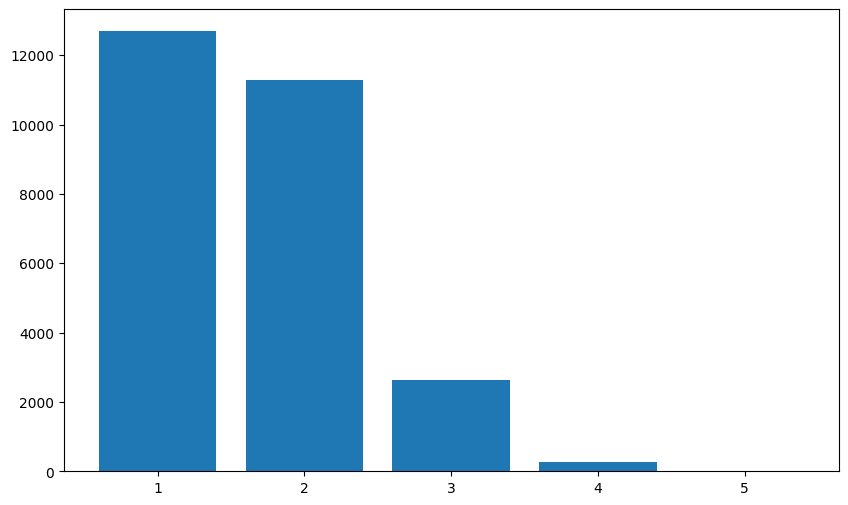

category_id
1    12689
2    11282
3     2626
4      265
5        2
Name: count, dtype: int64


In [10]:
unique_box = df.groupby('image_id')['category_id'].nunique().value_counts()
unique_box_num = np.arange(1, len(unique_box)+1)

plt.figure(figsize=(10, 6))
plt.bar(unique_box_num, unique_box)
plt.show()

print(unique_box)

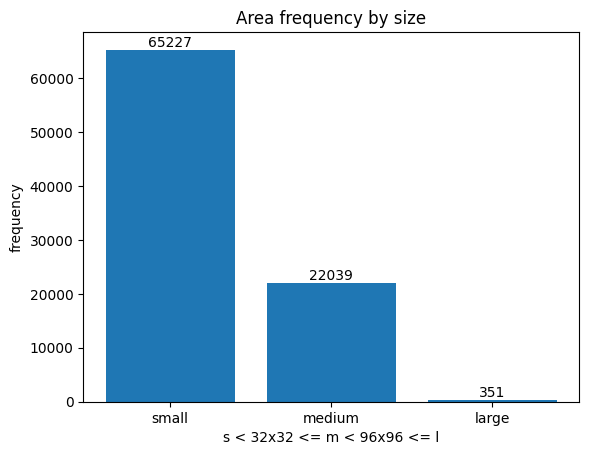

In [11]:
from collections import Counter
size_label= {0:'small', 1:'medium', 2:'large'}
digitized = np.digitize(df['area'], bins=[32**2, 96**2], right=True)

digitized = list(map(lambda x: size_label[x], digitized))
size_count = Counter(digitized)
size_count.items()
size_x = size_count.keys()
size_y = size_count.values()

plt.bar(size_x,size_y)

for x, y in zip(size_x, size_y):
    plt.text(x, y, str(y), ha='center', va='bottom')

plt.title('Area frequency by size')
plt.xlabel('s < 32x32 <= m < 96x96 <= l')
plt.ylabel('frequency')
plt.show()

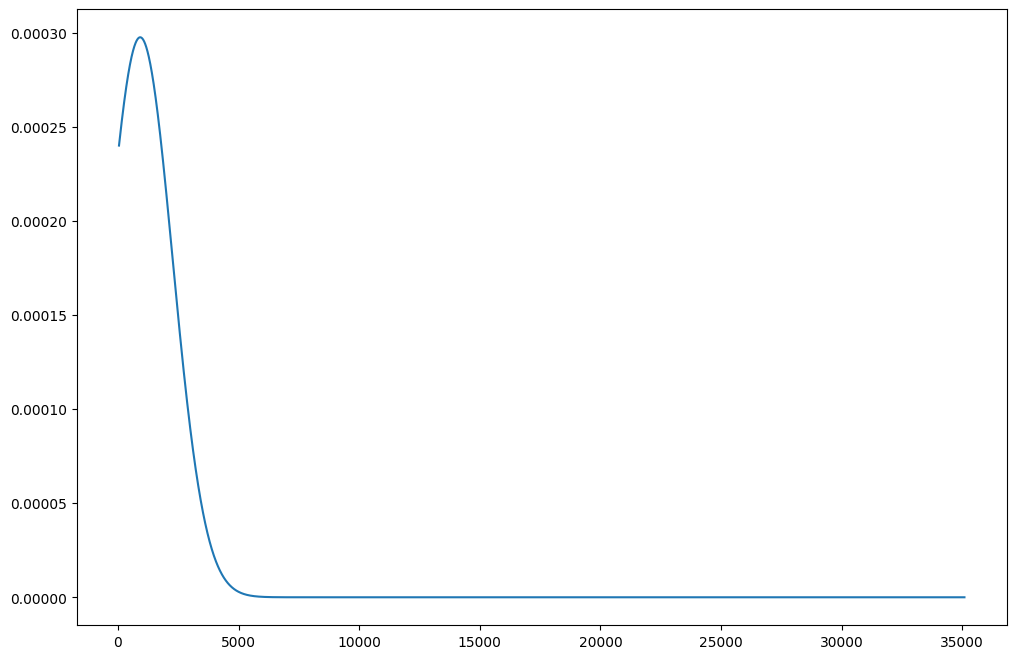

In [12]:
import scipy.stats as stats
area = df['area'].sort_values()
df_mean = np.mean(df['area'])
df_std = np.std(df['area'])
pdf = stats.norm.pdf(df["area"].sort_values(), df_mean, df_std)
plt.figure(figsize = (12,8))
plt.plot(area, pdf)
plt.show()

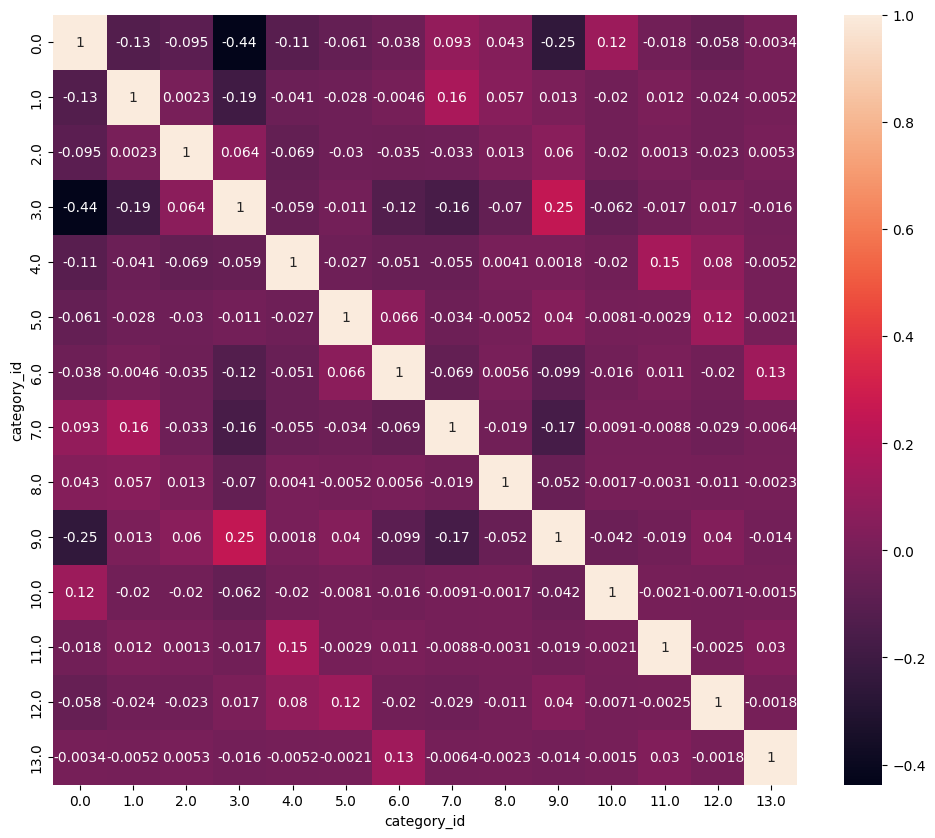

In [13]:
correlation_matrix = df.groupby('image_id')['category_id'].value_counts().unstack(fill_value=0)
correlation_matrix = correlation_matrix.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

# 이미지별 시각화

In [32]:
def get_img(filename):
    for img in data['images']:
        if img['file_name'] == filename:
            return img


def get_img_ann(image_id):
    img_ann = []
    isFound = False
    for ann in data['annotations']:
        if ann['image_id'] == image_id:
            img_ann.append(ann)
            isFound = True
    if isFound:
        return img_ann
    else:
        return print(image_id)

In [75]:
import random
import cv2
import os

BOX_COLOR = [(255, 20, 147), (57, 255, 20), (255, 255, 51), (255, 102, 0), (0, 204, 255), (160, 32, 240), 
             (255, 0, 255), (0, 255, 255), (255, 69, 0), (0, 255, 127), (255, 105, 180), (255, 20, 147), (173, 255, 47), (0, 0, 0)]
TEXT_COLOR = (255, 255, 255)


def visualize_bbox(img, bbox, class_name, color, idx, thickness=2):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name + f' {str(idx)}', cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), color, -1)
    cv2.putText(
        img,
        text=class_name + f' {str(idx)}',
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for idx, (bbox, category_id) in enumerate(zip(bboxes, category_ids)):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name, BOX_COLOR[category_id], idx)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [76]:
num = 5400 # image_id_number
# root = './train'
image = f'{str(num).zfill(8)}.jpg'

img = get_img(image)
img_id = img['id']
print(img_id)
img_ann = get_img_ann(img_id)

bboxes = []
category_ids = []
if img_ann:
    for ann in img_ann:
        current_category = ann['category_id']
        current_bbox = ann['bbox']
        x = current_bbox[0]
        y = current_bbox[1]
        w = current_bbox[2]
        h = current_bbox[3]
        
        bboxes.append([x, y, w, h])
        category_ids.append(current_category)

img_BGR = cv2.imread(os.path.join(img_dir, image), cv2.IMREAD_COLOR)
img = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)

5400


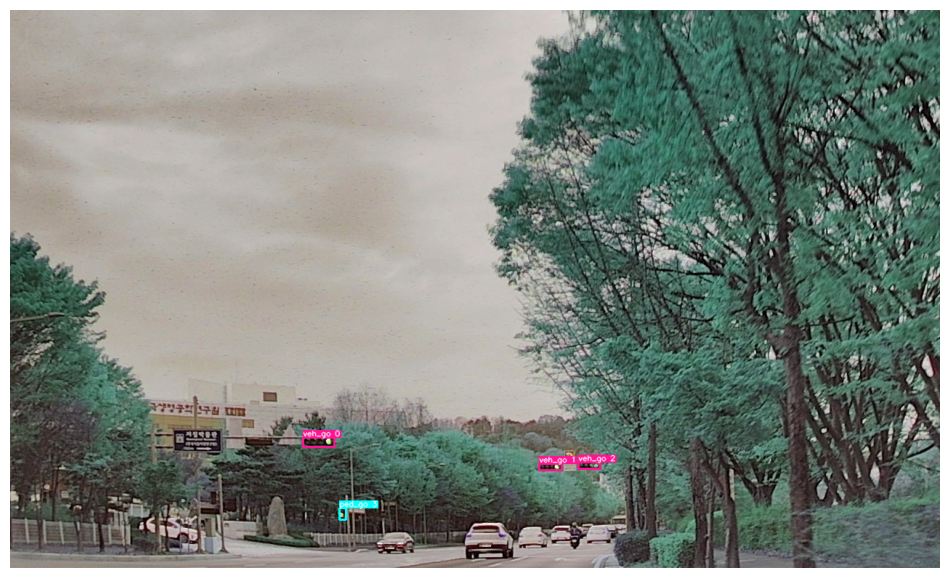

In [77]:
category_id_to_name = {
    0: 'veh_go',
    1: 'veh_goLeft',
    2: 'veh_noSign',
    3: 'veh_stop',
    4: 'veh_stopLeft',
    5: 'veh_stopWarning',
    6: 'veh_warning',
    7: 'ped_go',
    8: 'ped_noSign',
    9: 'ped_stop',
    10: 'bus_go',
    11: 'bus_noSign',
    12: 'bus_stop',
    13: 'bus_warning'
}
visualize(img, bboxes, category_ids, category_id_to_name)

# 전체 bbox의 너비와 높이에 대한 평균과 표준편차

In [67]:
bounding_boxes = []
categories_ids = []
width = []
height = []
def bboxes_gen(num):    
    image = f'{str(num).zfill(8)}.jpg'

    img = get_img(image)
    img_id = img['id']

    img_ann = get_img_ann(img_id)

    if img_ann:
        for ann in img_ann:
            current_category = ann['category_id']
            current_bbox = ann['bbox']
            x = current_bbox[0]
            y = current_bbox[1]
            w = current_bbox[2]
            h = current_bbox[3]
            
            bounding_boxes.append([x, y, w, h])
            categories_ids.append(current_category)
            width.append(w)
            height.append(h)


In [68]:
for i in tqdm(range(26864)):
    bboxes_gen(i)

  0%|          | 0/26864 [00:00<?, ?it/s]

In [69]:
width = np.array(width)
height = np.array(height)

print("mean of width: ", np.mean(width))
print("std of width: ", np.std(width))
print("mean of height: ", np.mean(height))
print("std of height: ", np.std(height))

mean of width:  39.92532867694626
std of width:  29.718597646457823
mean of height:  20.280291792140794
std of height:  16.589421828033256


# 전체 bbox의 종횡비

In [70]:
# 전체 bbox의 height/width를 0 ~ 10까지 0.1간격으로 구간화해서 빈도수를 구한다.
# ratio가 10 이상인 값은 적어서, 10으로 포함시켰다.
digitized = np.digitize(width/height*10, bins=np.arange(0,100), right=True)

df_bbox = pd.DataFrame({'grp_ratio':digitized*0.1, 'class':categories_ids})
df_ratio = df_bbox['grp_ratio'].value_counts().sort_index()

print(df_ratio.head(20))

grp_ratio
0.3     168
0.4    8161
0.5    6605
0.6    1994
0.7     247
0.8     348
0.9     892
1.0     745
1.1     861
1.2     109
1.3      20
1.4       5
1.5       1
1.6       8
1.7      99
1.8      80
1.9     321
2.0     299
2.1     708
2.2    1186
Name: count, dtype: int64


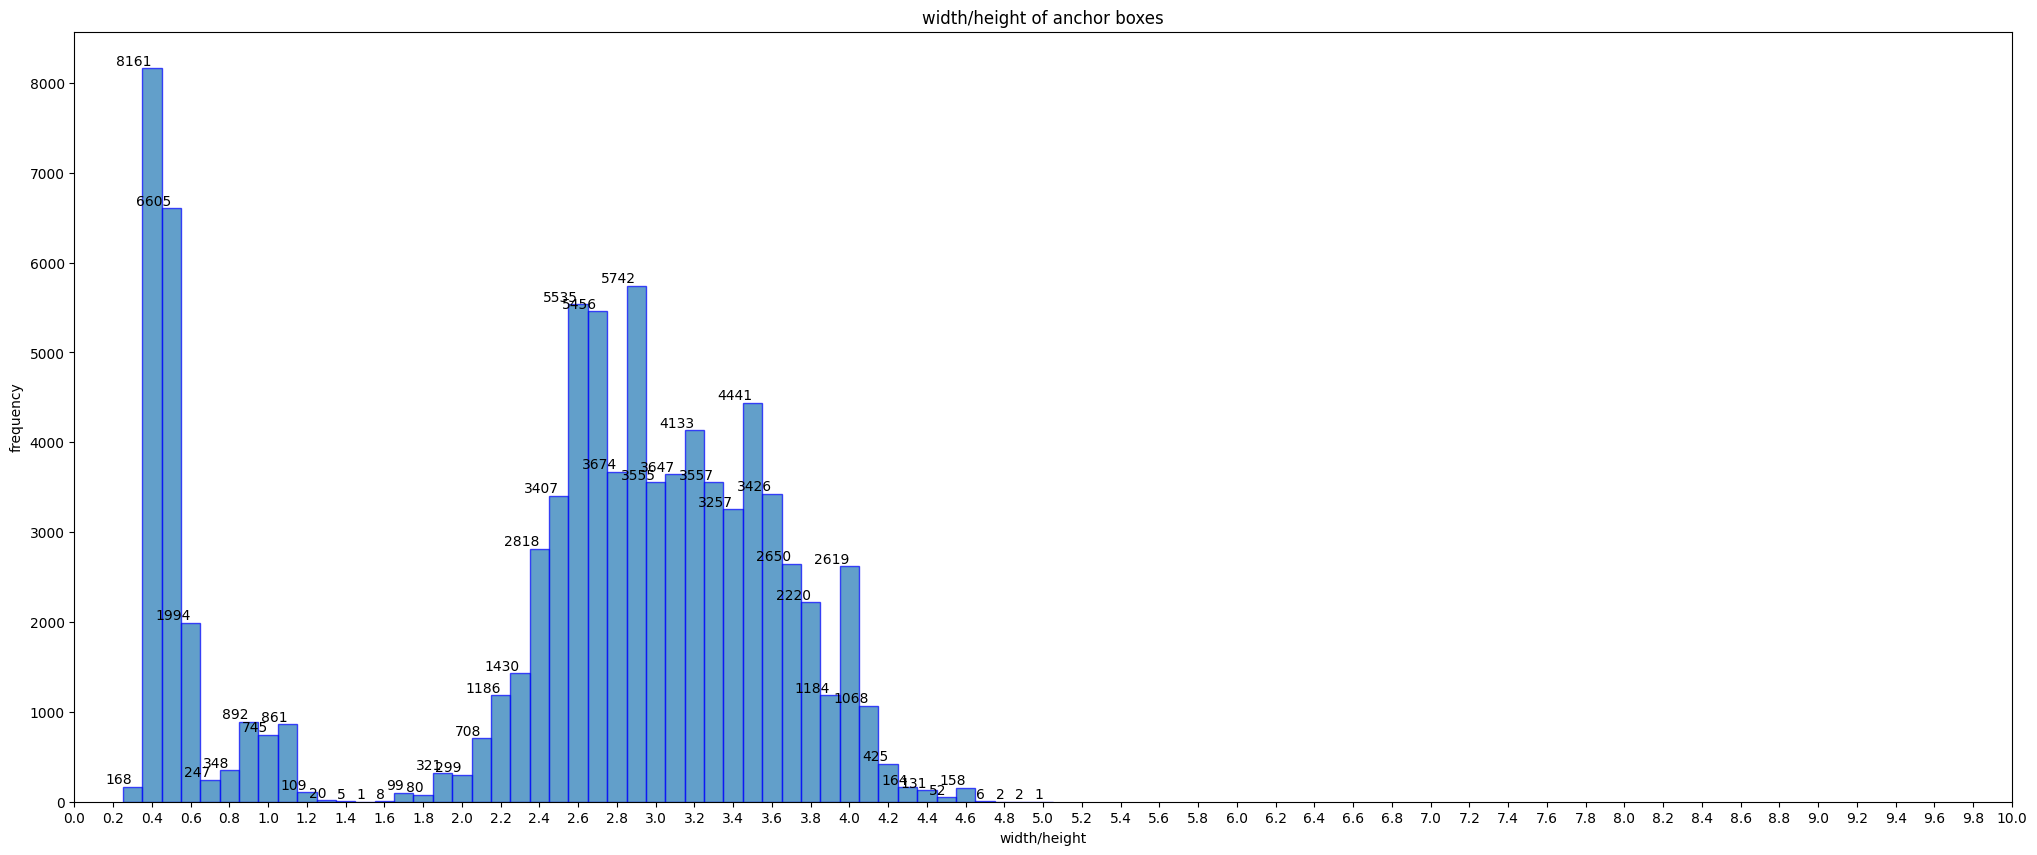

In [71]:
plt.figure(figsize=(25,10))
plt.bar(df_ratio.index, df_ratio.values, width = 0.1, edgecolor='blue', alpha=0.7)

for i, value in enumerate(df_ratio.values):
    plt.text(df_ratio.index[i], value + 0.1, str(value), ha='right', va='bottom')

plt.xticks(np.arange(0,10.1, 0.2))  # 예시로 0.5 간격으로 설정
plt.xlabel('width/height')
plt.ylabel('frequency')
plt.title('width/height of anchor boxes')
plt.show()

# 클래스별 bbox 종횡비 계산

/tmp/ipykernel_15332/2566763718.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_class, x='grp_ratio', y='count', hue = 'class', ci =None).set(xticks=np.arange(0,10,0.5),yticks=range(0,600,50))
/opt/conda/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you

[[<matplotlib.axis.XTick at 0x7fca647865c0>,

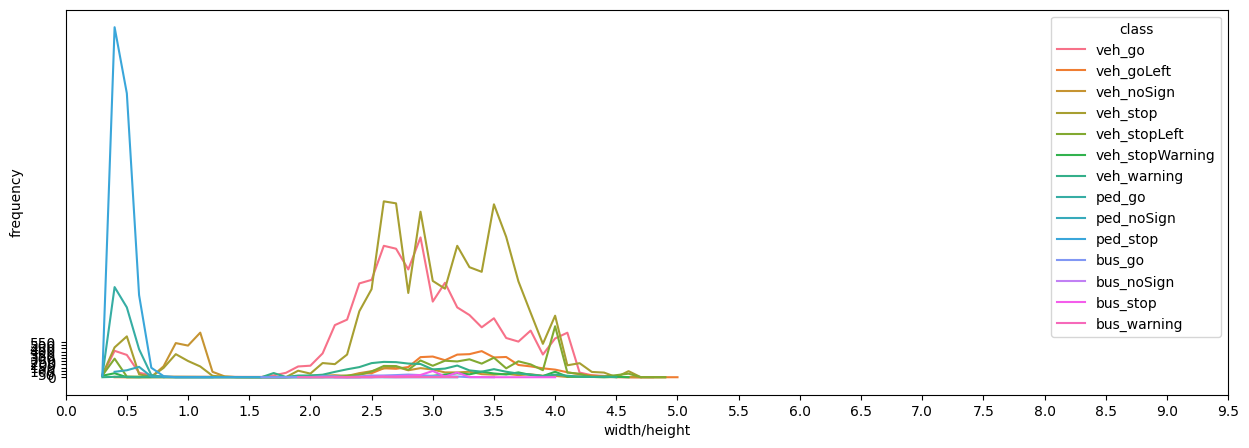

In [78]:
df_class = df_bbox.groupby(['class']).value_counts()
df_class = pd.DataFrame(df_class)
df_class = df_class.reset_index()

df_class['class']=df_class['class'].map(lambda x: category_id_to_name[x])
plt.figure(figsize=(15,5))
plt.xlabel('width/height')
plt.ylabel('frequency')
sns.lineplot(data=df_class, x='grp_ratio', y='count', hue = 'class', ci =None).set(xticks=np.arange(0,10,0.5),yticks=range(0,600,50))


# 전체 bbox 시각화 - 신호등이 이미지 좌상단에 집중되어있다.

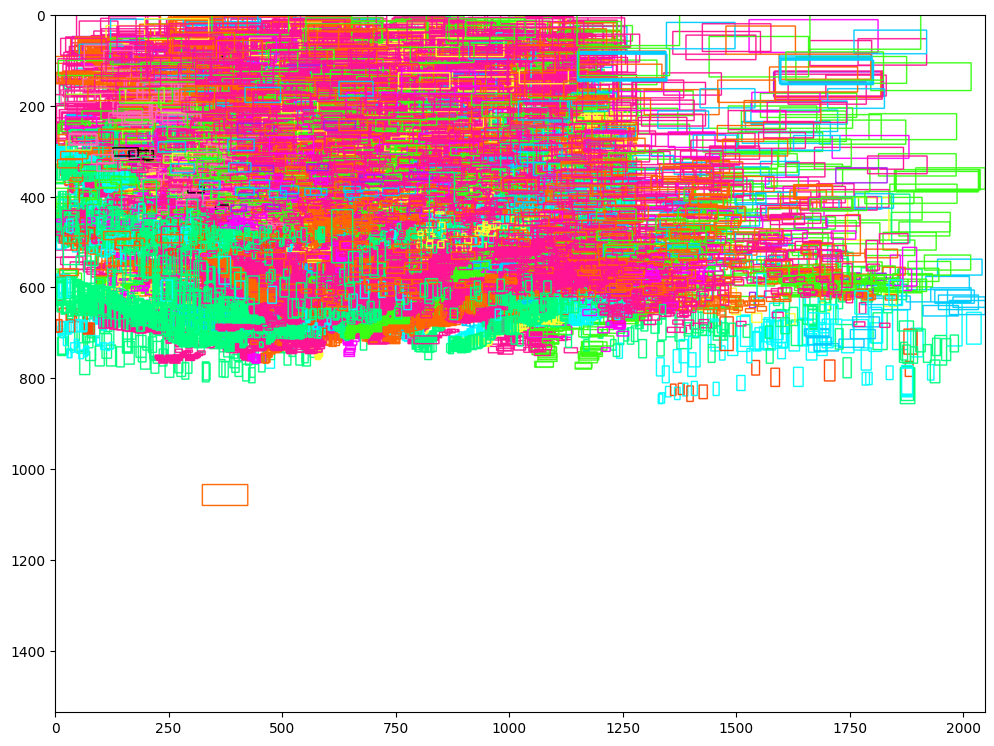

In [86]:
img0 = np.ones((1536,2048,3),np.uint8)*255
def visualize_bbox2(img, bbox, color, thickness=2):
    x_min, y_min, w, h = bbox
    # x_min = int(512 - 0.5*w)
    # y_min = int(512 - 0.5*h)
    # x_max = int(512 + 0.5*w)
    # y_max = int(512 + 0.5*h)
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    return img

def visualize2(image, bboxes, category_ids):
    for bbox, category_id in zip(bboxes,category_ids):
        img = visualize_bbox2(image, bbox, BOX_COLOR[category_id])
    plt.figure(figsize=(12, 12))
    # plt.axis('off')
    plt.imshow(img)
    
visualize2(img0, bounding_boxes, categories_ids)

# NMS 구현 

In [87]:
def approximate_nms(boxes, iou_threshold=0.5):
    """
    Confidence score가 없는 경우의 근사 NMS 구현
    :param boxes: bounding box 리스트 (각 bounding box는 [x, y, width, height] 형식)
    :param iou_threshold: NMS IoU 임계값
    :return: NMS가 적용된 bounding box 리스트
    """
    nms_boxes = []

    # boxes를 좌표값 기준으로 정렬
    boxes.sort(key=lambda x: x[0])

    while len(boxes) > 0:
        # 가장 왼쪽에 있는 box를 선택하고 결과 리스트에 추가
        selected_box = boxes.pop(0)
        nms_boxes.append(selected_box)

        # 선택한 box와의 IoU를 계산하여 IoU가 일정 임계값 이상인 box는 리스트에서 제거
        boxes = [box for box in boxes if calculate_iou(selected_box, box) < iou_threshold]

    return nms_boxes

def calculate_iou(box1, box2):
    """
    두 bounding box 간의 IoU (Intersection over Union) 계산
    :param box1: 첫 번째 bounding box [x1, y1, width1, height1]
    :param box2: 두 번째 bounding box [x2, y2, width2, height2]
    :return: IoU 값
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    intersection_x = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
    intersection_y = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))

    intersection_area = intersection_x * intersection_y
    union_area = w1 * h1 + w2 * h2 - intersection_area

    iou = intersection_area / union_area if union_area > 0 else 0
    return iou

# 예시 bounding box 리스트 (confidence score가 없는 경우)
boxes = [[50, 50, 100, 100], [75, 75, 100, 100], [150, 50, 100, 100], [200, 200, 100, 100]]

# 근사 NMS 적용
nms_result = approximate_nms(boxes)

# 결과 출력
print("Original Boxes:", boxes)
print("NMS Result:", nms_result)

Original Boxes: [[75, 75, 100, 100], [150, 50, 100, 100], [200, 200, 100, 100]]
NMS Result: [[50, 50, 100, 100], [75, 75, 100, 100], [150, 50, 100, 100], [200, 200, 100, 100]]


In [88]:
def group_boxes_by_class(boxes):
    """
    클래스 정보를 기준으로 bounding box를 묶어 딕셔너리로 반환
    :param boxes: bounding box 리스트 (각 bounding box는 [class, x, y, width, height] 형식)
    :return: 클래스로 묶인 bounding box 딕셔너리
    """
    grouped_boxes = {}
    for box in boxes:
        class_label = box[0]
        if class_label not in grouped_boxes:
            grouped_boxes[class_label] = []
        grouped_boxes[class_label].append(box[1:])

    return grouped_boxes

def approximate_nms_with_class(boxes, iou_threshold=0.99):
    nms_boxes = []

    # boxes를 좌표값 기준으로 정렬
    boxes.sort(key=lambda x: x[0])
    boxes = group_boxes_by_class(boxes)

    for k, boxs in boxes.items():
        if len(boxs) <= 1:
            nms_boxes.append([k, *boxs[0]])
            return nms_boxes
        while len(boxs) > 1:
            # 가장 왼쪽에 있는 box를 선택하고 결과 리스트에 추가
            selected_box = boxs.pop(0)
            selected_box = [k, *selected_box]
            nms_boxes.append(selected_box)
            # 선택한 box와의 IoU를 계산하여 IoU가 일정 임계값 이상인 box는 리스트에서 제거
            boxes = [box for box in boxs if calculate_iou(selected_box, box) < iou_threshold]
    if boxes:
        nms_boxes.append([k, *boxes[0]])
            # boxes.insert(1, k)

    return nms_boxes

def calculate_iou(box1, box2):
    c, x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    intersection_x = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
    intersection_y = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))

    intersection_area = intersection_x * intersection_y
    union_area = w1 * h1 + w2 * h2 - intersection_area

    iou = intersection_area / union_area if union_area > 0 else 0
    return iou

# 예시 bounding box 리스트 (confidence score가 없는 경우)
boxes_with_class = [
    [0, 50, 50, 100, 100],
    [1, 75, 75, 100, 100],
    [0, 50, 50, 100, 100],
    [1, 100, 100, 100, 100],
    [1, 100, 100, 100, 100],
    [2, 50, 150, 100, 100],
]

# 근사 NMS 적용
nms_result_with_class = approximate_nms_with_class(boxes_with_class)

# 결과 출력
print("Original Boxes with Class:", boxes_with_class)
print("NMS Result with Class:", nms_result_with_class)


Original Boxes with Class: [[0, 50, 50, 100, 100], [0, 50, 50, 100, 100], [1, 75, 75, 100, 100], [1, 100, 100, 100, 100], [1, 100, 100, 100, 100], [2, 50, 150, 100, 100]]
NMS Result with Class: [[0, 50, 50, 100, 100], [1, 75, 75, 100, 100], [1, 100, 100, 100, 100], [2, 50, 150, 100, 100]]


In [89]:
def nms_dataset(input_json):
    with open(input_json) as f:
        data = json.load(f)

    var = [(ann['image_id'], ann['category_id']) for ann in data['annotations']]
    groups = np.array([v[0] for v in var])

    
    images = data['images']
    annotations = data['annotations']
        
    train_images = [x for x in images if x.get('id') in groups]
    train_annotations = [x for x in annotations if x.get('image_id') in groups]
    k = 0
    nms_train_annotations = []
    for image in tqdm(images):
        annos = []
        for anno in annotations:
            if image['id'] == anno['image_id']:
                annos.append([anno['category_id'], anno['bbox'][0], anno['bbox'][1], anno['bbox'][2], anno['bbox'][3]])
        d = approximate_nms_with_class(annos)
        for i in d:
            tmp = {}
            tmp['image_id'] = image['id']
            tmp['category_id'] = i[0]
            tmp['area'] = i[3] * i[4]
            tmp['bbox'] = [i[1], i[2], i[3], i[4]]
            tmp['iscrowd'] = 0
            tmp['id'] = k
            k += 1
            nms_train_annotations.append(tmp)
        
        
    train_data = {
        'info' : data['info'],
        'licenses' : data['licenses'],
        'images' : train_images,
        'categories' : data['categories'],
        'annotations' : nms_train_annotations
        }


    with open(f'./train_nms_thresh99.json', 'w') as f:
        json.dump(train_data, f, indent=4)


In [ ]:
import json
from tqdm import tqdm
nms_dataset('/workspace/mm/dataset/train_fold_4.json')